In [32]:
import functools
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import sys
sys.path.append("..")
from melolib.notation import DurationClass, Rest, Duration
from melolib.music import Note

In [33]:
duration_repr_to_class = {
    "w": DurationClass.Whole,
    "h": DurationClass.Half,
    "q": DurationClass.Quarter,
    "8": DurationClass.Eighth,
    "16": DurationClass.Sixteenth,
    "32": DurationClass.ThirtySecond,
    "64": DurationClass.SixtyFourth,
}

def parse_duration(duration):
    r = duration.rstrip(".")
    duration_class = duration_repr_to_class[r]
    num_dots = len(duration) - len(r)
    return Duration(duration_class, num_dots)

def parse_note(note):
    note, octave = note.split("/")
    return Note.from_name(note, int(octave))

def duration_to_tensor(duration):
    d = parse_duration(duration)
    du = torch.zeros(len(DurationClass))
    du[d.duration_class.value] = 1
    do = torch.zeros(3)
    do[d.dots] = 1
    return torch.cat((du, do))

def note_to_tensor(note, is_rest):
    if is_rest:
        return torch.zeros(22)

    n = parse_note(note)
    key = torch.zeros(12)
    octave = torch.zeros(10)
    key[Note.chromatic_sharps.index(n.get_name()[0])] = 1
    octave[n.get_name()[1]] = 1
    return torch.cat((key, octave))

def notation_to_tensor(notation):
    note = note_to_tensor(notation["key"], "r" in notation["duration"])
    duration = duration_to_tensor(notation["duration"].replace("r", ""))
    return torch.cat((note, duration))

class MidiMelodyDataset(Dataset):
    def __init__(self, filename="../../out/melody.json"):
        with open(filename) as f:
            songs = json.load(f)

        melodies = []
        for song in songs:
            for track in song:
                d = track["data"]
                k = track["key_signature"]
                l = len(d) - len(d) % 25
                for i in range(0, len(d), 25):
                    line = d[25 * i: 25 * (i+1)]
                    key_tensor = torch.zeros(12)
                    key_tensor[Note.chromatic_sharps.index(k[0][0])] = 1
                    line_tensors = [torch.cat((key_tensor, notation_to_tensor(x))) for x in line]
                    if len(line) == 25:
                        melodies.append((k, line_tensors[1:], line_tensors[:-1]))
        
        self.data = []
        for (k, x, y) in melodies:
            self.data.append((torch.stack(list(x)), torch.stack(list(y))))        
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = MidiMelodyDataset()
train_dataset, test_dataset = random_split(dataset, [0.80, 0.20])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

OUTPUT_SIZE = 12 + 12 + 10 + len(DurationClass) + 3
INPUT_SIZE = OUTPUT_SIZE

print(f"Input size: {INPUT_SIZE}")

Input size: 44


In [34]:
class GRUNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, state_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.state_size = hidden_size
        self.output_size = output_size

        self.gru = torch.nn.GRU(self.input_size, self.state_size, num_layers=1, batch_first=True)
        self.h2h = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.h2o = torch.nn.Linear(self.hidden_size, self.output_size)

    def forward(self, i: torch.Tensor, state: torch.Tensor):
        h, s = self.gru(i, state)
        h2 = self.h2h(torch.relu(h))
        o = self.h2o(torch.relu(h2))

        split_outputs = torch.split(o, [12, 12, 10, 7, 3], dim=-1)
        o = [F.log_softmax(o, dim=-1) for o in split_outputs]
        o = torch.cat(o, dim=-1)
        return o, s

    def init_hidden(self, batch_size=None):
        if batch_size is None:
            return torch.zeros((1, self.hidden_size))
        return torch.zeros((1, batch_size, self.hidden_size))

In [35]:
def train_loop(dataloader, model, loss, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (x, y) in enumerate(dataloader):
        state = model.init_hidden(x.size(dim=0))
        cost = 0
        for i in range(x.size(1)):
            pred, state = model(x[:, i:i+1, :], state)
            pred = torch.squeeze(pred, dim=1)
            y_ = torch.squeeze(y[:, i:i+1, :], dim=1)
            split_predictions = torch.split(pred, [12, 12, 10, 7, 3], dim=-1)
            split_y= torch.split(y_, [12, 12, 10, 7, 3], dim=-1)
            cost += sum(loss(p, torch.argmax(y__, dim=-1)) for p, y__ in zip(split_predictions, split_y))
        cost /= x.size(0) * x.size(1)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_loss = cost.item()
        total_loss += batch_loss

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx} loss: {batch_loss}")

    return total_loss / len(dataloader)


def test_loop(dataloader, model, loss, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(dataloader):
            state = model.init_hidden(x.size(dim=0))
            cost = 0
            for i in range(x.size(1)):
                pred, state = model(x[:, i:i+1, :], state)
                pred = torch.squeeze(pred, dim=1)
                y_ = torch.squeeze(y[:, i:i+1, :], dim=1)
                split_predictions = torch.split(pred, [12, 12, 10, 7, 3], dim=-1)
                split_y= torch.split(y_, [12, 12, 10, 7, 3], dim=-1)
                cost += sum(loss(p, torch.argmax(y__, dim=-1)) for p, y__ in zip(split_predictions, split_y))
            cost /= x.size(0) * x.size(1)               
            batch_loss = cost.item()
            test_loss += batch_loss

    return test_loss / len(dataloader)


Using cpu device
Batch 0 loss: 0.6521996259689331
Batch 100 loss: 0.34595322608947754
Batch 200 loss: 0.19960099458694458
---------------
Epoch: 1
Loss in training:  0.3551093847945679
Loss in test: 0.215661165063028
---------------

Batch 0 loss: 0.1998380869626999
Batch 100 loss: 0.1440504938364029
Batch 200 loss: 0.11469203233718872
---------------
Epoch: 2
Loss in training:  0.15618829179641813
Loss in test: 0.11486306234642311
---------------

Batch 0 loss: 0.11020363122224808
Batch 100 loss: 0.08327683806419373
Batch 200 loss: 0.06122876703739166
---------------
Epoch: 3
Loss in training:  0.08703954108925753
Loss in test: 0.06739805783662531
---------------

Batch 0 loss: 0.06538736075162888
Batch 100 loss: 0.04934234544634819
Batch 200 loss: 0.035183705389499664
---------------
Epoch: 4
Loss in training:  0.052317171543836596
Loss in test: 0.04125159865038262
---------------

Batch 0 loss: 0.03810790926218033
Batch 100 loss: 0.026109203696250916
Batch 200 loss: 0.02379908412694

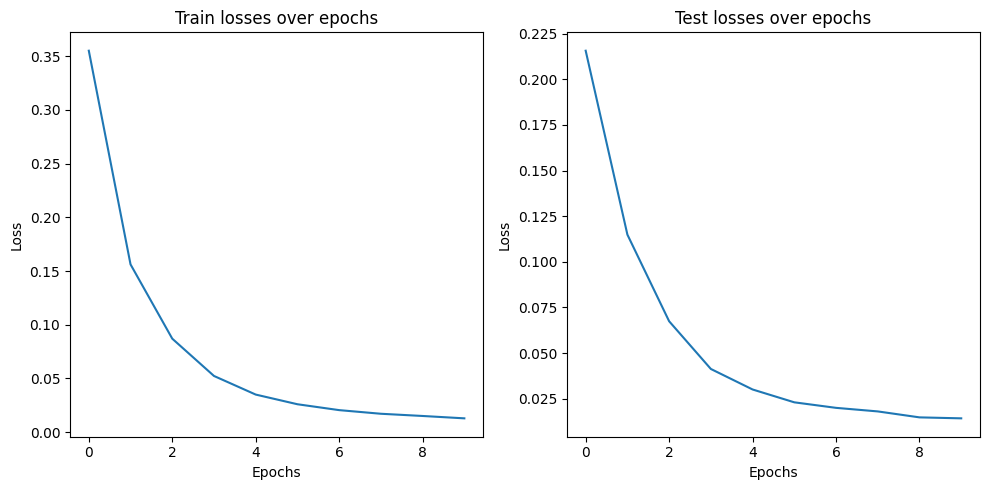

Batch 0 loss: 0.012639506720006466
Batch 100 loss: 0.014619797468185425
Batch 200 loss: 0.008745419792830944
---------------
Epoch: 11
Loss in training:  0.012114562134280108
Loss in test: 0.012757564196363091
---------------

Batch 0 loss: 0.009036754257977009
Batch 100 loss: 0.010821429081261158
Batch 200 loss: 0.009942767210304737
---------------
Epoch: 12
Loss in training:  0.011034329952455537
Loss in test: 0.012875614325619407
---------------

Batch 0 loss: 0.013157729990780354
Batch 100 loss: 0.007461369503289461
Batch 200 loss: 0.0072619072161614895
---------------
Epoch: 13
Loss in training:  0.011042546048803732
Loss in test: 0.011704764346143714
---------------

Batch 0 loss: 0.008890246972441673
Batch 100 loss: 0.0103842094540596
Batch 200 loss: 0.0120523227378726
---------------
Epoch: 14
Loss in training:  0.009920667927322347
Loss in test: 0.011052095253641406
---------------

Batch 0 loss: 0.008710741065442562
Batch 100 loss: 0.00737491762265563
Batch 200 loss: 0.013401

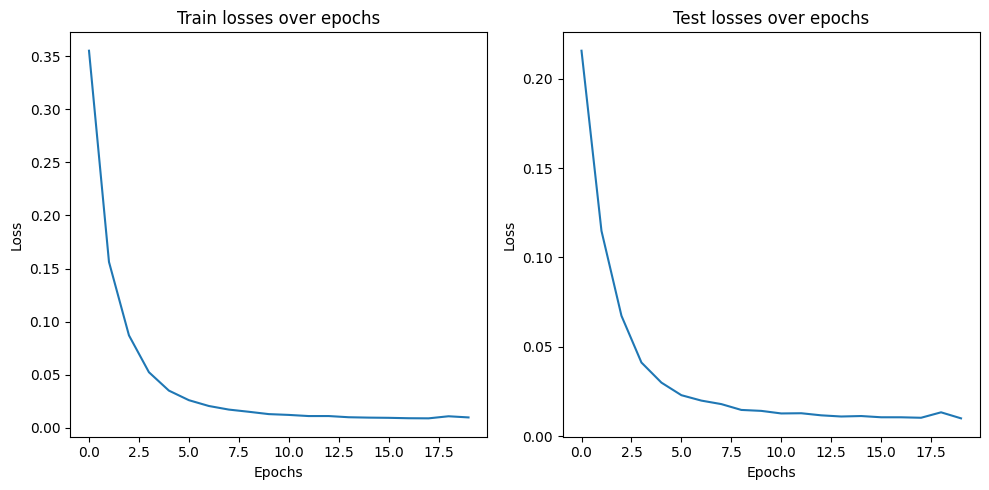

In [37]:
HIDDEN_SIZE = 25
STATE_SIZE = 16


def plot(epochs, train_losses, test_losses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(epochs, train_losses)
    ax1.set_title('Train losses over epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(epochs, test_losses)
    ax2.set_title('Test losses over epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    plt.tight_layout()
    plt.show()

def main():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
    print(f"Using {device} device")

    model = GRUNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, STATE_SIZE).to(device)
    loss = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    epochs = 20
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train_loss = train_loop(train_dataloader, model, loss, optimizer, epoch)
        test_loss = test_loop(test_dataloader, model, loss, epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print("---------------")
        print(f"Epoch: {epoch+1}")
        print("Loss in training: ", train_loss)
        print("Loss in test:", test_loss)
        print("---------------\n")
        if (epoch + 1) % 10 == 0:
            plot(range(0, epoch + 1), train_losses, test_losses)
        
    torch.save(model.state_dict(), "../../out/rnn_melody.pth")

main()

In [ ]:
def tensor_to_notation(tensor):
    key, note, octave, duration, dots = torch.split(tensor, [12, 12, 10, 7, 3])
    
    key_prob = torch.exp(key)
    key_prob /= torch.sum(key_prob)
    
    note_prob = torch.exp(note)
    note_prob /= torch.sum(note_prob)
    
    octave_prob = torch.exp(octave)
    octave_prob /= torch.sum(octave_prob)

    duration_prob = torch.exp(duration)
    duration_prob /= torch.sum(duration_prob)

    dots_prob = torch.exp(dots)
    dots_prob /= torch.sum(dots_prob)

    
    octave_labels = list(range(10))
    duration_labels = ['Whole', 'Half', 'Quarter', 'Eighth', 'Sixteenth', 'Thirty-second', 'Sixty-fourth']
    dots_labels = [0, 1, 2]

    key_prob_dict = {key_label: prob.item() for key_label, prob in zip(Note.chromatic_sharps, key_prob)}
    note_prob_dict = {note_label: prob.item() for note_label, prob in zip(Note.chromatic_sharps, note_prob)}
    octave_prob_dict = {str(octave_label): prob.item() for octave_label, prob in zip(octave_labels, octave_prob)}
    duration_prob_dict = {duration_label: prob.item() for duration_label, prob in zip(duration_labels, duration_prob)}
    dots_prob_dict = {dots_label: prob.item() for dots_label, prob in zip(dots_labels, dots_prob)}

    
    # print(key_prob_dict)
    print(note_prob_dict)
    # print(octave_prob_dict)
    # print(duration_prob_dict)
    # print(dots_prob_dict)


def argmax_to_one_hot(tensor):
    argmax_index = torch.argmax(tensor)
    one_hot_tensor = torch.zeros_like(tensor)
    one_hot_tensor[argmax_index] = 1
    return one_hot_tensor

def tensor_to_discrete(tensor):
    key, note, octave, duration, dots = torch.split(tensor, [12, 12, 10, 7, 3])
    
    key_prob = torch.exp(key)
    key_prob /= torch.sum(key_prob)
    
    note_prob = torch.exp(note)
    note_prob /= torch.sum(note_prob)
    
    octave_prob = torch.exp(octave)
    octave_prob /= torch.sum(octave_prob)

    duration_prob = torch.exp(duration)
    duration_prob /= torch.sum(duration_prob)

    dots_prob = torch.exp(dots)
    dots_prob /= torch.sum(dots_prob)
    f = argmax_to_one_hot
    return torch.cat((f(key_prob), f(note_prob), f(octave_prob), f(duration_prob), f(dots_prob)))


def sandbox():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")
    model = GRUNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, STATE_SIZE).to(device)
    model.load_state_dict(torch.load("../../out/rnn_melody.pth"))
    model.eval()
    # np.set_printoptions(threshold=10_000)
    # torch.set_printoptions(profile="full")

    with torch.no_grad():
        while True:
            try:
                key = input("Enter key: ").strip()
                notations = input("Enter notation list: ").strip()
            except KeyboardInterrupt:
                break

            if key == "" or notations == "":
                break

            key_tensor = torch.zeros(12)
            key_tensor[Note.chromatic_sharps.index(key)] = 1
            notations = [notation.split("-") for notation in notations.split(" ")]
            input_tensors = []
            for note, duration in notations:
                is_rest = "r" in duration
                notation_tensor = notation_to_tensor({"key": note, "duration": duration})
                input_tensors.append(torch.cat((key_tensor, notation_tensor)))
            seq_len = len(input_tensors)
            input_tensors.extend([input_tensors[-1]] * (24 - len(input_tensors)))
            x = torch.stack(input_tensors)
    
            state = model.init_hidden()
            pred = None
            for i in range(seq_len - 1):
                pred, state = model(x[i:i+1, :], state)
            
            pred, state = model(x[seq_len -1:seq_len], state)
            t = torch.squeeze(pred)
            tensor_to_notation(t)
            print()

            for i in range(5):
                pred = torch.unsqueeze(tensor_to_discrete(torch.squeeze(pred)), dim=0)
                pred, state = model(pred, state)
                t = torch.squeeze(pred)
                tensor_to_notation(t)
                print()
sandbox()

Using cpu device


Enter key:  C
Enter notation list:  B/4-qr


{'C': 0.6838619112968445, 'C#': 0.0002308234543306753, 'D': 0.10897619277238846, 'D#': 0.0003668200224637985, 'E': 0.060176342725753784, 'F': 0.0839858278632164, 'F#': 3.7889643863309175e-05, 'G': 0.03308798000216484, 'G#': 1.722337765386328e-05, 'A': 0.010018494911491871, 'A#': 0.00017287119408138096, 'B': 0.0190676748752594}

{'C': 0.9999831914901733, 'C#': 1.865323420355801e-14, 'D': 8.104208291115356e-07, 'D#': 3.616566118580522e-06, 'E': 1.2333889571891632e-05, 'F': 4.8127430929412185e-09, 'F#': 1.6672470348755297e-10, 'G': 5.743705343156172e-14, 'G#': 3.120248850962959e-11, 'A': 2.5461150717925757e-18, 'A#': 1.395119020308755e-10, 'B': 3.4840508950084725e-11}

{'C': 1.0, 'C#': 7.730001309695106e-22, 'D': 4.785915663774176e-08, 'D#': 3.312594365478816e-10, 'E': 8.663359807314919e-09, 'F': 2.5122861690290987e-13, 'F#': 1.0768821137553328e-15, 'G': 3.783311701836245e-17, 'G#': 3.634586116624313e-18, 'A': 9.862360730747983e-25, 'A#': 2.338296072542409e-15, 'B': 2.8309347227698054e-16